In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customers/extract - fees - data analyst - .csv
/kaggle/input/bank-customers/extract - cash request - data analyst.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [3]:
fees= pd.read_csv('/kaggle/input/bank-customers/extract - fees - data analyst - .csv')
cash_request= pd.read_csv('/kaggle/input/bank-customers/extract - cash request - data analyst.csv')

In [4]:
cash_request.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [5]:
cr= cash_request.copy()
cr=cr[['amount','created_at', 'user_id', 'deleted_account_id', 'transfer_type']]
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   amount              23970 non-null  float64
 1   created_at          23970 non-null  object 
 2   user_id             21867 non-null  float64
 3   deleted_account_id  2104 non-null   float64
 4   transfer_type       23970 non-null  object 
dtypes: float64(3), object(2)
memory usage: 936.5+ KB


In [6]:
cr.fillna({'user_id':cr['deleted_account_id']}, inplace=True)
cr.drop(columns=['deleted_account_id'], inplace=True)
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   amount         23970 non-null  float64
 1   created_at     23970 non-null  object 
 2   user_id        23970 non-null  float64
 3   transfer_type  23970 non-null  object 
dtypes: float64(2), object(2)
memory usage: 749.2+ KB


In [7]:
cr['created_at']=pd.to_datetime(cr['created_at'])
cr.head()

,amount,created_at,user_id,transfer_type
0,100.0,2019-12-10 19:05:21.596873+00:00,804.0,regular
1,100.0,2019-12-10 19:50:12.347780+00:00,231.0,regular
2,100.0,2019-12-10 19:13:35.825460+00:00,191.0,regular
3,99.0,2019-12-10 19:16:10.880172+00:00,761.0,regular
4,100.0,2020-05-06 09:59:38.877376+00:00,7686.0,regular


In [8]:
cr['created_at']=cr['created_at'].dt.tz_localize(None)
cr.head()

,amount,created_at,user_id,transfer_type
0,100.0,2019-12-10 19:05:21.596873,804.0,regular
1,100.0,2019-12-10 19:50:12.347780,231.0,regular
2,100.0,2019-12-10 19:13:35.825460,191.0,regular
3,99.0,2019-12-10 19:16:10.880172,761.0,regular
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular


In [9]:
cr['Month']=cr['created_at'].dt.to_period('M')
cr.head()

,amount,created_at,user_id,transfer_type,Month
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05


In [10]:
cr['Cohort']=cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
cr.head()

,amount,created_at,user_id,transfer_type,Month,Cohort
0,100.0,2019-12-10 19:05:21.596873,804.0,regular,2019-12,2019-12
1,100.0,2019-12-10 19:50:12.347780,231.0,regular,2019-12,2019-12
2,100.0,2019-12-10 19:13:35.825460,191.0,regular,2019-12,2019-12
3,99.0,2019-12-10 19:16:10.880172,761.0,regular,2019-12,2019-12
4,100.0,2020-05-06 09:59:38.877376,7686.0,regular,2020-05,2020-05


In [11]:
# calculate the number of the unique customers in each cohort
cohort_initial_sizes= cr.groupby('Cohort').agg(
    Number_of_initial_customers=('user_id', 'nunique')
).reset_index()
cohort_initial_sizes

,Cohort,Number_of_initial_customers
0,2019-11,1
1,2019-12,254
2,2020-01,106
3,2020-02,90
4,2020-03,86
5,2020-04,246
6,2020-05,432
7,2020-06,1540
8,2020-07,1482
9,2020-08,728


In [12]:
cohort_monthly_sizes= cr.groupby(['Cohort','Month']).agg(Number_of_customers=('user_id', 'nunique')).reset_index()
cohort_monthly_sizes

,Cohort,Month,Number_of_customers
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,680
79,2020-09,2020-11,20
80,2020-10,2020-10,4802
81,2020-10,2020-11,15


In [13]:
cohort_cash_monthly= cr.groupby(['Cohort','Month']).agg(Num_requests=('user_id', 'count')).reset_index()
cohort_cash_monthly

,Cohort,Month,Num_requests
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,727
79,2020-09,2020-11,20
80,2020-10,2020-10,5043
81,2020-10,2020-11,15


In [14]:
# calculate customer retention rate (unique customers per cohort in each month/initial customers in the cohort)
customers_retention= cohort_monthly_sizes.pivot(index='Cohort' , columns='Month' , values='Number_of_customers')
customers_retention= customers_retention.div(cohort_initial_sizes.set_index('Cohort')['Number_of_initial_customers'], axis=0)

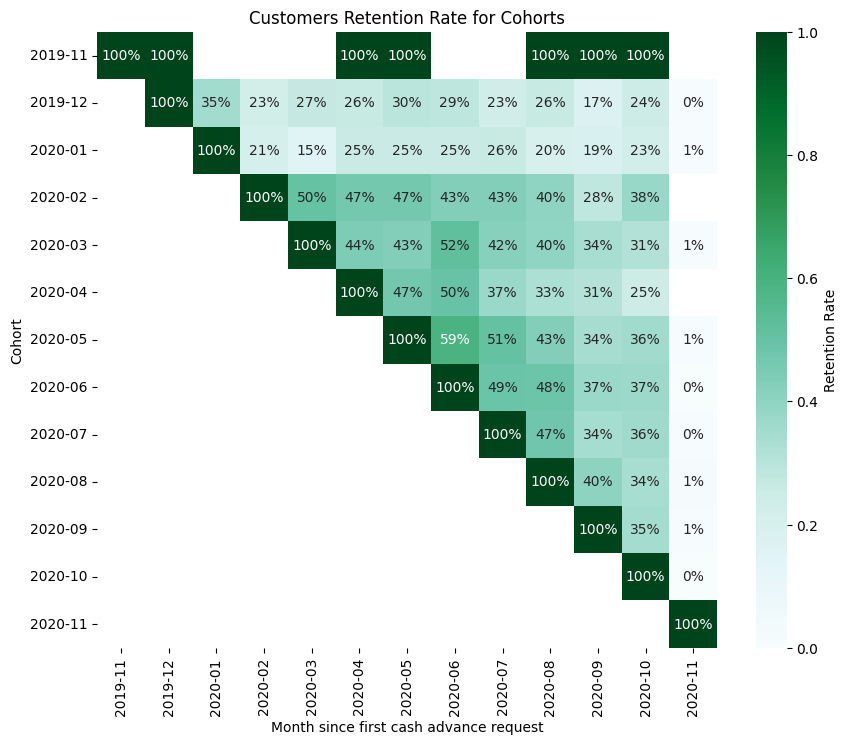

In [15]:
# Show the retention rate with heat map 
plt.figure(figsize=(10, 8))
plt.title('Customers Retention Rate for Cohorts')
sns.heatmap(data=customers_retention,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=1.0,
            cmap='BuGn',
            cbar_kws={'label':'Retention Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')
plt.show()

Text(95.72222222222221, 0.5, 'Cohort')

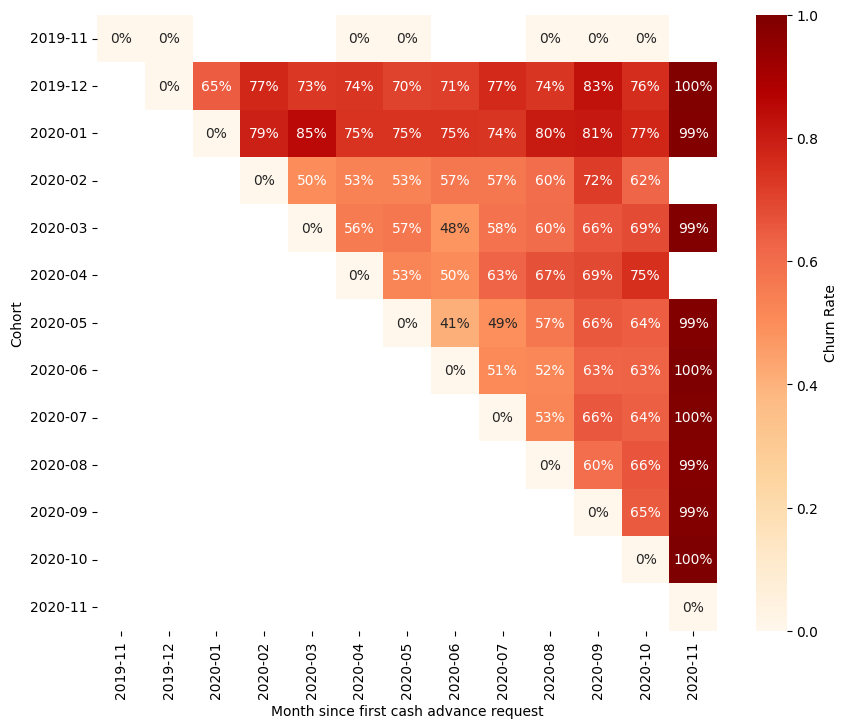

In [16]:
# calculate Churn Rate 
# Churn_rate= 1- retention_rate
churn_rate= 1- customers_retention

# plot the Churn rate 
plt.figure(figsize=(10, 8))
sns.heatmap(data=churn_rate,
            annot=True,
            fmt='.0%',
            vmin=0.0 ,
            vmax=1.0,
            cmap='OrRd',
            cbar_kws={'label':'Churn Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')

In [17]:
# calculate the initial number of cash advance requests in each cohort
cohort_cash_initial= cohort_cash_monthly.groupby('Cohort').first().reset_index().rename(columns={'Num_requests':'Num_initial_requests'})
cohort_cash_initial

,Cohort,Month,Num_initial_requests
0,2019-11,2019-11,1
1,2019-12,2019-12,288
2,2020-01,2020-01,117
3,2020-02,2020-02,97
4,2020-03,2020-03,99
5,2020-04,2020-04,264
6,2020-05,2020-05,478
7,2020-06,2020-06,1934
8,2020-07,2020-07,1996
9,2020-08,2020-08,993


In [18]:
# Request Retention Rate (for Cohorts in Each Month/ Number of Initial Request of Cohort)
retention_request= cohort_cash_monthly.pivot(index='Cohort', columns='Month', values='Num_requests')
retention_request= retention_request.div(cohort_cash_initial.set_index('Cohort')['Num_initial_requests'], axis=0)
retention_request

Month,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohort,,,,,,,,,,,,,
2019-11,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,2.000000,NaN
2019-12,NaN,1.0,0.368056,0.218750,0.274306,0.284722,0.298611,0.315972,0.250000,0.291667,0.184028,0.260417,0.003472
2020-01,NaN,NaN,1.000000,0.205128,0.145299,0.299145,0.264957,0.247863,0.264957,0.188034,0.188034,0.213675,0.008547
2020-02,NaN,NaN,NaN,1.000000,0.505155,0.505155,0.463918,0.463918,0.463918,0.453608,0.278351,0.412371,NaN
2020-03,NaN,NaN,NaN,NaN,1.000000,0.424242,0.464646,0.474747,0.404040,0.363636,0.303030,0.303030,0.010101
2020-04,NaN,NaN,NaN,NaN,NaN,1.000000,0.568182,0.571970,0.439394,0.405303,0.337121,0.284091,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.665272,0.573222,0.485356,0.376569,0.364017,0.008368
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.531024,0.494829,0.355222,0.339193,0.002585
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.471443,0.304609,0.298096,0.003507


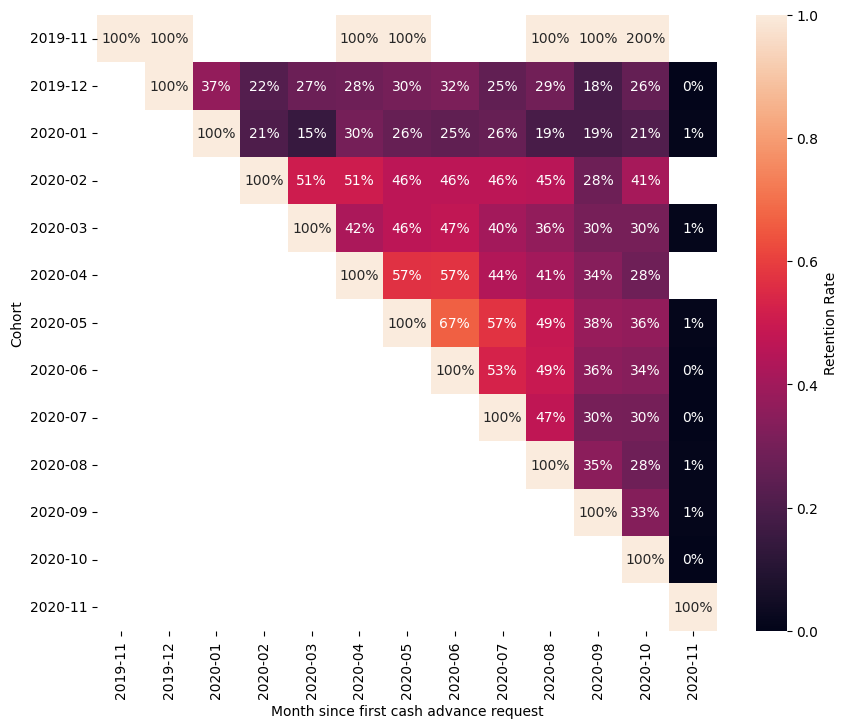

In [19]:
plt.figure(figsize=(10,8))
sns.color_palette("YlOrBr", as_cmap=True)
sns.heatmap(data=retention_request,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=1.0,
            cbar_kws={'label':'Retention Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')
plt.show()

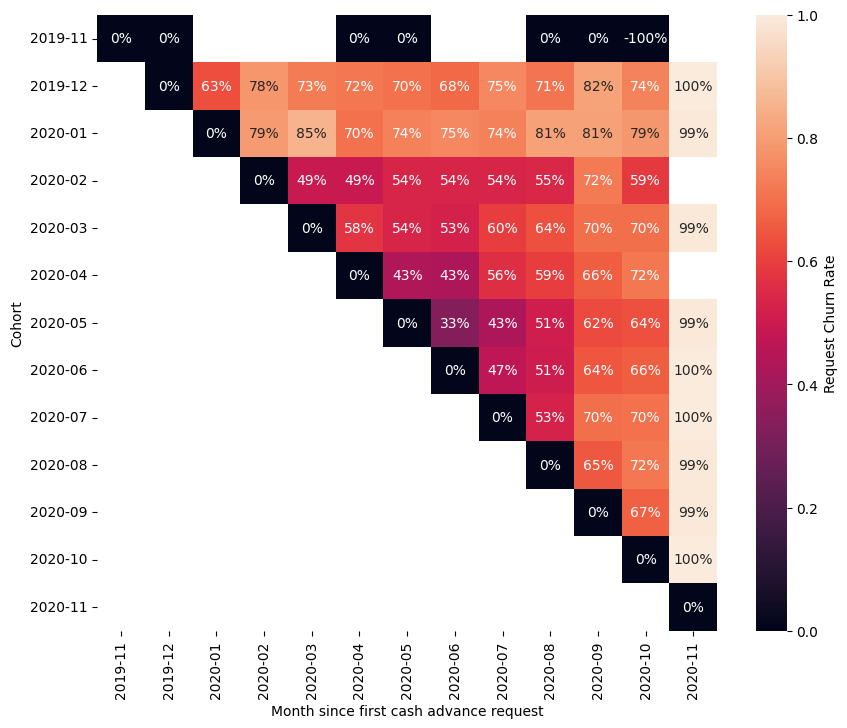

In [20]:
# Cash Request Churn Rate 
request_churn_rate = 1 - retention_request
plt.figure(figsize=(10,8))
sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(data=request_churn_rate,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=1.0,
            cbar_kws={'label':'Request Churn Rate'})
plt.xlabel('Month since first cash advance request')
plt.ylabel('Cohort')
plt.show()

In [21]:
cohort_2020_02 = retention_request.loc['2020-02']
df = cohort_2020_02.reset_index()
df.columns = ['Month', 'Retention_Rate']  # Renaming columns
df


# Convert 'Month' from Period to datetime
df['Month'] = df['Month'].astype(str)  # Convert to string
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

# Convert 'Fecha_Compra' to numerical values (months since first purchase)
df['Month_Num'] = (df['Month'] - df['Month'].min()).dt.days // 30

df

,Month,Retention_Rate,Month_Num
0,2019-11-01,NaN,0
1,2019-12-01,NaN,1
2,2020-01-01,NaN,2
3,2020-02-01,1.000000,3
4,2020-03-01,0.505155,4
5,2020-04-01,0.505155,5
6,2020-05-01,0.463918,6
7,2020-06-01,0.463918,7
8,2020-07-01,0.463918,8
9,2020-08-01,0.453608,9


In [22]:
from sklearn.model_selection import KFold, train_test_split,cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

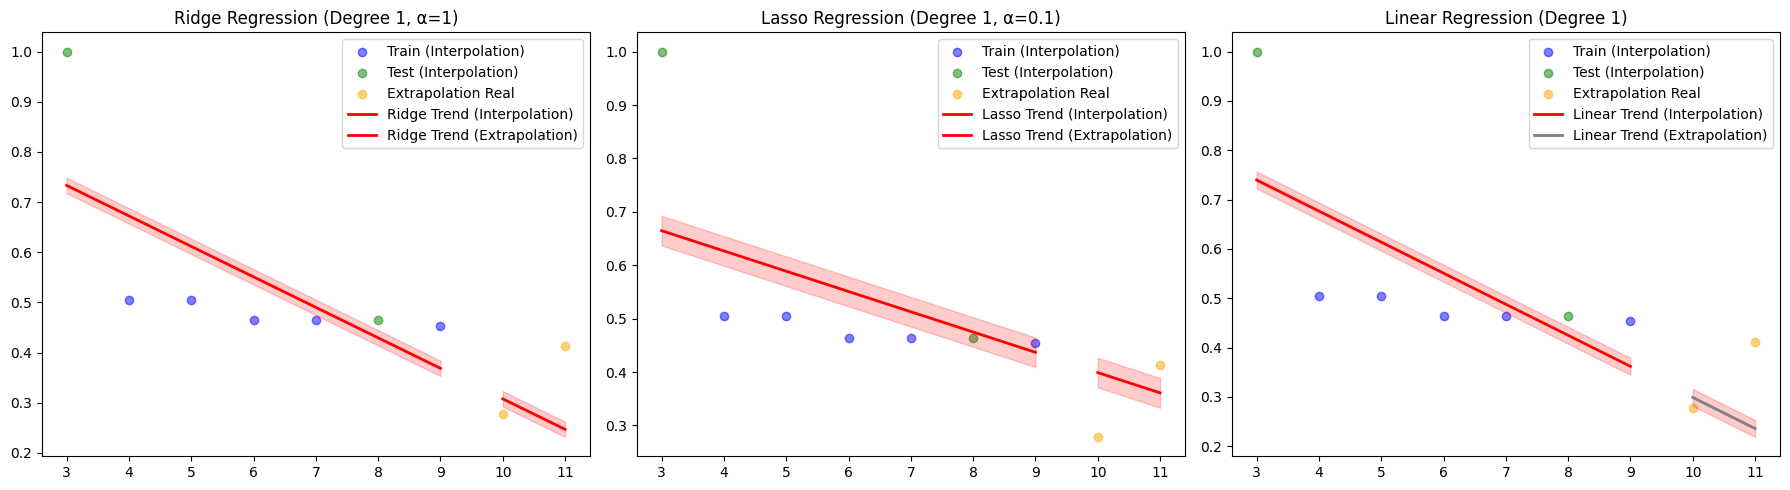

Degree 1: Ridge (α=1, MSE=-0.4754),R2_Score=0.5058, R2_Score_Extrapolation=-2.145751035887057
Degree 1: Lasso (α=0.1, MSE=-0.4784),R2_Score=-0.5625, R2_Score_Extrapolation=-0.9137484905204716
Degree 1: Linear (MSE=-0.4741),R2_Score=0.3645, R2_Score_Extrapolation=-2.5107022098780334


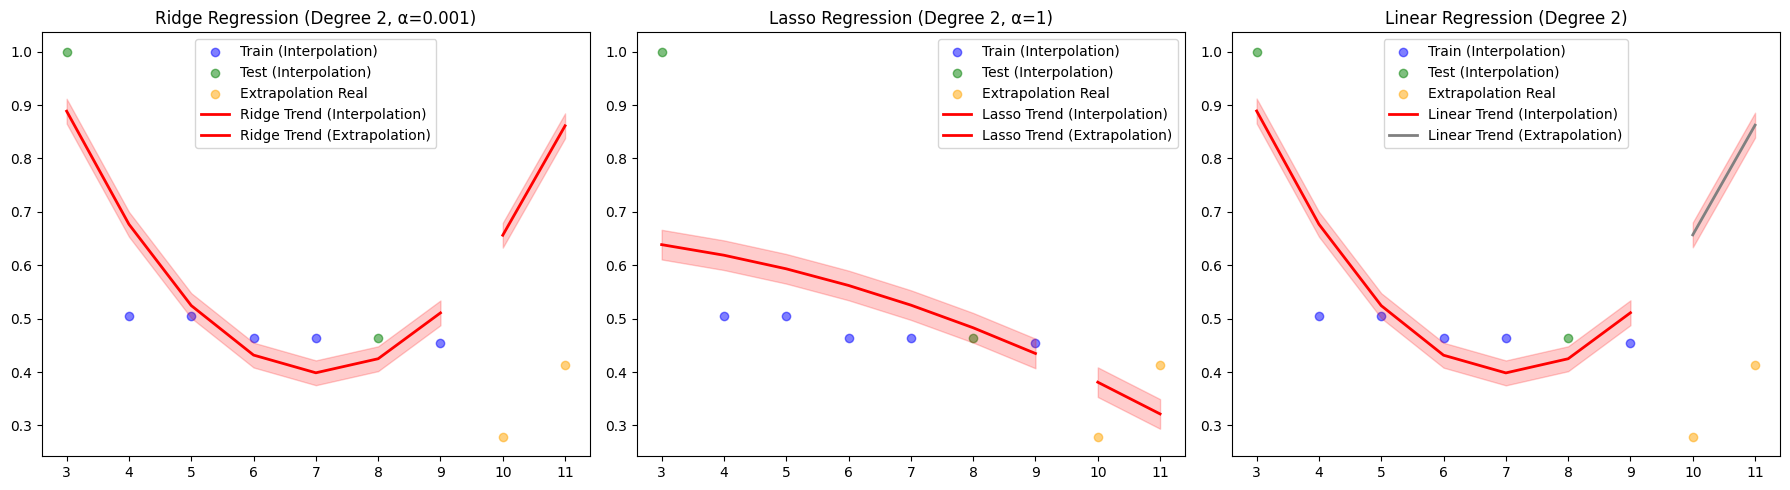

Degree 2: Ridge (α=0.001, MSE=-0.4788),R2_Score=-0.0956, R2_Score_Extrapolation=-37.317450272506036
Degree 2: Lasso (α=1, MSE=-0.4784),R2_Score=-0.5625, R2_Score_Extrapolation=-1.0914369898103788
Degree 2: Linear (MSE=-0.4790),R2_Score=-0.1052, R2_Score_Extrapolation=-37.49275449824915


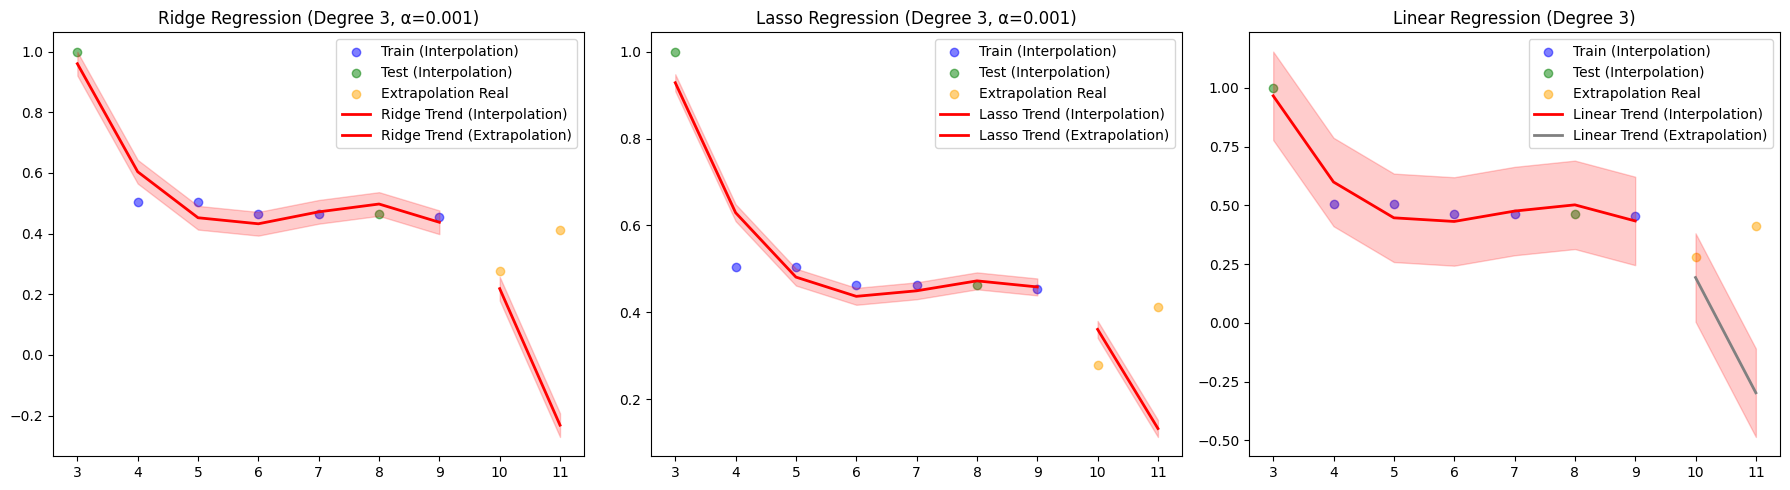

Degree 3: Ridge (α=0.001, MSE=-0.4968),R2_Score=-2.7818, R2_Score_Extrapolation=-45.531465568463354
Degree 3: Lasso (α=0.001, MSE=-0.4763),R2_Score=0.2221, R2_Score_Extrapolation=-8.478570878010952
Degree 3: Linear (MSE=-0.5835),R2_Score=-93.2187, R2_Score_Extrapolation=-55.92259388963918


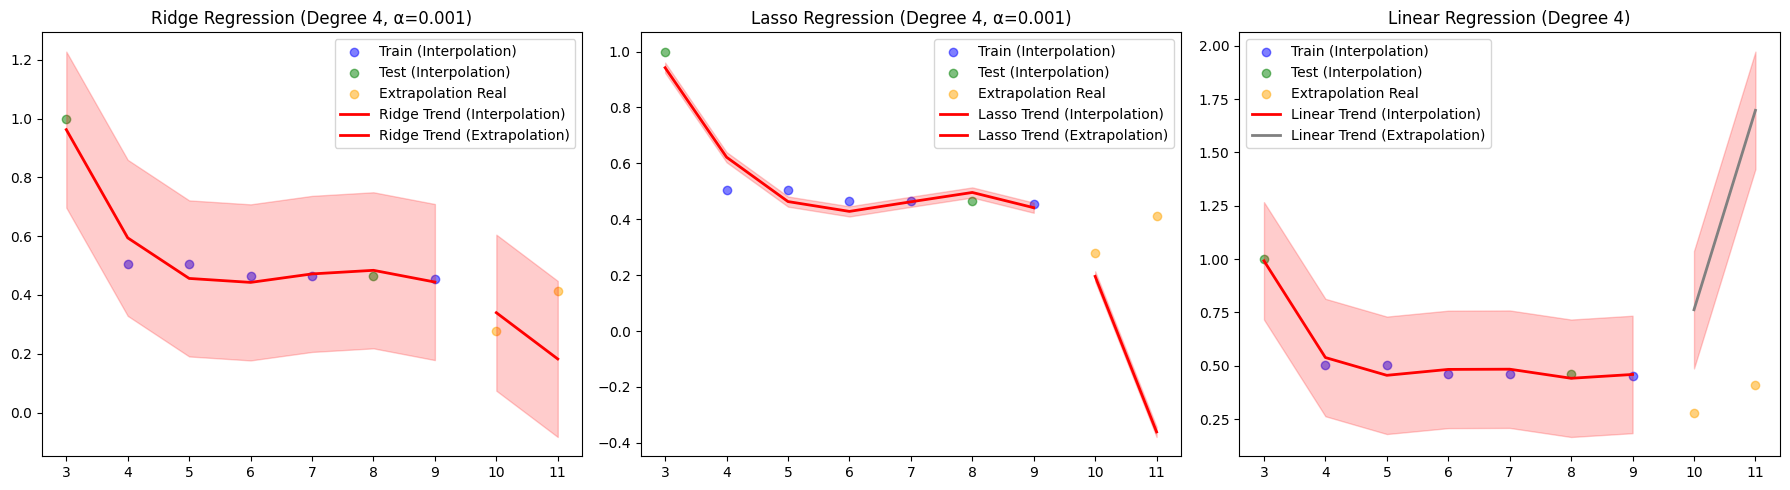

Degree 4: Ridge (α=0.001, MSE=-0.6169),R2_Score=-180.7746, R2_Score_Extrapolation=-5.308924977598762
Degree 4: Lasso (α=0.001, MSE=-0.4854),R2_Score=0.2304, R2_Score_Extrapolation=-66.37442077378753
Degree 4: Linear (MSE=-0.6221),R2_Score=-194.5159, R2_Score_Extrapolation=-208.99812825239704


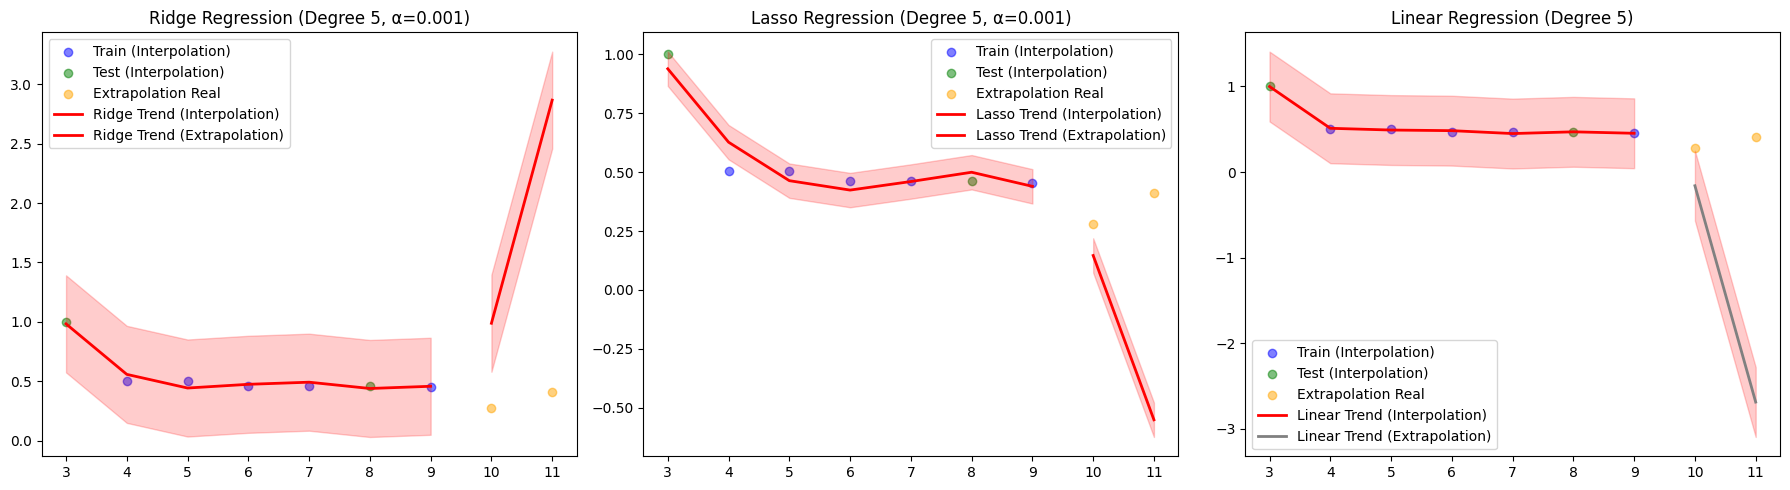

Degree 5: Ridge (α=0.001, MSE=-0.6832),R2_Score=-421.6441, R2_Score_Extrapolation=-725.0837932047256
Degree 5: Lasso (α=0.001, MSE=-0.5150),R2_Score=-12.5448, R2_Score_Extrapolation=-104.34211530318333
Degree 5: Linear (MSE=-0.6833),R2_Score=-422.1230, R2_Score_Extrapolation=-1091.3770234132537


In [23]:
# Define parameters
poly_degree = [1,2, 3, 4, 5]  # Polynomial degrees to test
alpha_values = [0.001, 0.01 ,0.1, 1]  # Regularization strengths
n_splits = 5  # Number of folds for cross-validation
random_state = 42  # Ensures reproducibility

df_train = df.dropna()  # Remove NaN values

# Convert to numpy arrays
X = np.array(df_train['Month_Num']).reshape(-1, 1)
y = np.array(df_train['Retention_Rate'])

# Split dataset into 80% interpolation and 20% extrapolation
X_interp, X_extrap, y_interp, y_extrap = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.2, shuffle=True)

# K-Fold Cross Validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Loop through each polynomial degree
for degree in poly_degree:
    best_ridge_alpha, best_lasso_alpha = None, None
    best_ridge_model, best_lasso_model, best_linear_model = None, None, None
    best_ridge_R2_sklearn, best_lasso_R2_sklearn, best_linear_R2_sklearn = None, None, None
    best_ridge_mse, best_lasso_mse, best_linear_mse = float('inf'), float('inf'), float('inf')

    # Loop through different alpha values for Ridge and Lasso
    for alpha in alpha_values:
        # Ridge Regression Model
        ridge_model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
        ridge_preds = cross_val_predict(ridge_model, X_train, y_train, cv=kf)
        ridge_std = np.std(y_train - ridge_preds)
        ridge_R2_sklearn = r2_score(y_train, ridge_preds)
               
        ridge_mse_scores = -cross_val_predict(ridge_model, X_train, y_train, cv=kf)
        ridge_mean_mse = np.mean(ridge_mse_scores)

        if ridge_mean_mse < best_ridge_mse:
            best_ridge_mse = ridge_mean_mse
            best_ridge_alpha = alpha
            best_ridge_model = ridge_model
            best_ridge_std = ridge_std
            best_ridge_R2_sklearn= ridge_R2_sklearn

        # Lasso Regression Model
        lasso_model = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha, max_iter=10000))
        lasso_preds = cross_val_predict(lasso_model, X_train, y_train, cv=kf)
        lasso_std = np.std(y_train - lasso_preds)
        lasso_R2_sklearn = r2_score(y_train, lasso_preds)

        lasso_mse_scores = -cross_val_predict(lasso_model, X_train, y_train, cv=kf)
        lasso_mean_mse = np.mean(lasso_mse_scores)

        if lasso_mean_mse < best_lasso_mse:
            best_lasso_mse = lasso_mean_mse
            best_lasso_alpha = alpha
            best_lasso_model = lasso_model
            best_lasso_std = lasso_std
            best_lasso_R2_sklearn= lasso_R2_sklearn
            
    # Linear Regression Model (no regularization)
    linear_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    linear_preds = cross_val_predict(linear_model, X_train, y_train, cv=kf)
    linear_std = np.std(y_train - linear_preds)
    linear_R2_sklearn = r2_score(y_train, linear_preds)

    
    linear_mse_scores = -cross_val_predict(linear_model, X_train, y_train, cv=kf)
    linear_mean_mse = np.mean(linear_mse_scores)

    best_linear_model = linear_model
    best_linear_std = linear_std
    best_linear_R2_sklearn= linear_R2_sklearn
    # Train the best models for this degree
    best_ridge_model.fit(X_interp, y_interp)
    best_lasso_model.fit(X_interp, y_interp)
    best_linear_model.fit(X_interp, y_interp)

    # Predictions
    ridge_y_predict_interp = best_ridge_model.predict(X_interp)
    ridge_y_predict_extra = best_ridge_model.predict(X_extrap)

    
    lasso_y_predict_interp = best_lasso_model.predict(X_interp)
    lasso_y_predict_extra = best_lasso_model.predict(X_extrap)
    
    
    linear_y_predict_interp = best_linear_model.predict(X_interp)
    linear_y_predict_extra = best_linear_model.predict(X_extrap)

    R2_sklearn_ridge = r2_score(y_extrap, ridge_y_predict_extra)
    R2_sklearn_lasso = r2_score(y_extrap, lasso_y_predict_extra)
    R2_sklearn_linear = r2_score(y_extrap, linear_y_predict_extra)

    # Plot results for this degree
    plt.figure(figsize=(18, 5))

    # Ridge Regression Plot
    plt.subplot(1, 3, 1)
    plt.scatter(X_train, y_train, label='Train (Interpolation)', color='blue', alpha=0.5)
    plt.scatter(X_test, y_test, label='Test (Interpolation)', color='green', alpha=0.5)
    plt.scatter(X_extrap, y_extrap, label='Extrapolation Real', color='orange', alpha=0.5)
    plt.plot(X_interp, ridge_y_predict_interp, label='Ridge Trend (Interpolation)', color='red', linewidth=2)
    plt.plot(X_extrap, ridge_y_predict_extra, label='Ridge Trend (Extrapolation)', color='red', linewidth=2)
    plt.fill_between(X_interp.flatten(), ridge_y_predict_interp - best_ridge_std, ridge_y_predict_interp + best_ridge_std, color='red', alpha=0.2)
    plt.fill_between(X_extrap.flatten(), ridge_y_predict_extra - best_ridge_std, ridge_y_predict_extra + best_ridge_std, color='red', alpha=0.2)
    plt.title(f'Ridge Regression (Degree {degree}, α={best_ridge_alpha})')
    plt.legend()

    # Lasso Regression Plot
    plt.subplot(1, 3, 2)
    plt.scatter(X_train, y_train, label='Train (Interpolation)', color='blue', alpha=0.5)
    plt.scatter(X_test, y_test, label='Test (Interpolation)', color='green', alpha=0.5)
    plt.scatter(X_extrap, y_extrap, label='Extrapolation Real', color='orange', alpha=0.5)
    plt.plot(X_interp, lasso_y_predict_interp, label='Lasso Trend (Interpolation)', color='red', linewidth=2)
    plt.plot(X_extrap, lasso_y_predict_extra, label='Lasso Trend (Extrapolation)', color='red', linewidth=2)
    plt.fill_between(X_interp.flatten(), lasso_y_predict_interp - best_lasso_std, lasso_y_predict_interp + best_lasso_std, color='red', alpha=0.2)
    plt.fill_between(X_extrap.flatten(), lasso_y_predict_extra - best_lasso_std, lasso_y_predict_extra + best_lasso_std, color='red', alpha=0.2)
    plt.title(f'Lasso Regression (Degree {degree}, α={best_lasso_alpha})')
    plt.legend()

    # Linear Regression Plot
    plt.subplot(1, 3, 3)
    plt.scatter(X_train, y_train, label='Train (Interpolation)', color='blue', alpha=0.5)
    plt.scatter(X_test, y_test, label='Test (Interpolation)', color='green', alpha=0.5)
    plt.scatter(X_extrap, y_extrap, label='Extrapolation Real', color='orange', alpha=0.5)
    plt.plot(X_interp, linear_y_predict_interp, label='Linear Trend (Interpolation)', color='red', linewidth=2)
    plt.plot(X_extrap, linear_y_predict_extra, label='Linear Trend (Extrapolation)', color='gray', linewidth=2)
    plt.fill_between(X_interp.flatten(), linear_y_predict_interp - best_linear_std, linear_y_predict_interp + best_linear_std, color='red', alpha=0.2)
    plt.fill_between(X_extrap.flatten(), linear_y_predict_extra - best_linear_std, linear_y_predict_extra + best_linear_std, color='red', alpha=0.2)
    plt.title(f'Linear Regression (Degree {degree})')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Degree {degree}: Ridge (α={best_ridge_alpha}, MSE={best_ridge_mse:.4f}),R2_Score={best_ridge_R2_sklearn:.4f}, R2_Score_Extrapolation={R2_sklearn_ridge}")
    print(f"Degree {degree}: Lasso (α={best_lasso_alpha}, MSE={best_lasso_mse:.4f}),R2_Score={best_lasso_R2_sklearn:.4f}, R2_Score_Extrapolation={R2_sklearn_lasso}")
    print(f"Degree {degree}: Linear (MSE={linear_mean_mse:.4f}),R2_Score={best_linear_R2_sklearn:.4f}, R2_Score_Extrapolation={R2_sklearn_linear}")


In [24]:
# Merge datasets using cash_request_id from fees and id from cash_request
merged_df = fees.merge(cash_request, left_on='cash_request_id', right_on='id', how='inner')

# Drop redundant columns (ensure 'id_y' exists before dropping)
if 'id_y' in merged_df.columns:
    merged_df = merged_df.drop(columns=["id_y"])

# Rename columns for clarity
merged_df.rename(columns={"id_x": "fee_id", "cash_request_id": "cash_request_id"}, inplace=True)

#  Correct Column Naming
if 'created_at_y' in merged_df.columns:  # Prefer cash request date
    merged_df['created_at_cash_request'] = merged_df['created_at_y']
    merged_df = merged_df.drop(columns=["created_at_y"])
    if 'created_at_x' in merged_df.columns:  # Use fee date if cash request date is missing
        merged_df['created_at_fees'] = merged_df['created_at_x']
        merged_df = merged_df.drop(columns=["created_at_x"])
else:
    raise KeyError("Column 'created_at' not found in merged dataset")

#  Convert 'created_at_cash_request' to datetime
merged_df['created_at_cash_request'] = pd.to_datetime(merged_df['created_at_cash_request'], errors='coerce')

#  Create Month Column for Cash Request
merged_df['Month_cash_request'] = merged_df['created_at_cash_request'].dt.to_period('M')
merged_df['Month_cash_request'] = merged_df['Month_cash_request'].astype(str)  # Convert to string
merged_df['Month_cash_request'] = pd.to_datetime(merged_df['Month_cash_request'], format='%Y-%m')

merged_df['Month_Num_cash_request'] = ((merged_df['Month_cash_request'] - merged_df['Month_cash_request'].min()).dt.days // 30)

#  Convert 'created_at_fees' to datetime
merged_df['created_at_fees'] = pd.to_datetime(merged_df['created_at_fees'], errors='coerce')

#  Create Month Column for Fees
merged_df['Month_fees'] = merged_df['created_at_fees'].dt.to_period('M')
merged_df['Month_fees'] = merged_df['Month_fees'].astype(str)  # Convert to string
merged_df['Month_fees'] = pd.to_datetime(merged_df['Month_fees'], format='%Y-%m')

merged_df['Month_Num_fees'] = ((merged_df['Month_fees'] - merged_df['Month_fees'].min()).dt.days // 30)

#  Display the merged dataset info
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21057 entries, 0 to 21056
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   fee_id                      21057 non-null  int64              
 1   cash_request_id             21057 non-null  float64            
 2   type                        21057 non-null  object             
 3   status_x                    21057 non-null  object             
 4   category                    2196 non-null   object             
 5   total_amount                21057 non-null  float64            
 6   reason                      21057 non-null  object             
 7   updated_at_x                21057 non-null  object             
 8   paid_at                     15531 non-null  object             
 9   from_date                   7766 non-null   object             
 10  to_date                     7766 non-null   object        

In [25]:
import plotly.express as px 

fig= px.imshow(merged_df.isnull(),
              color_continuous_scale=['gray','green'],
              labels=dict(color='NaN'),
              title='Color Map for the Merged Data Frame(Inner Join)')
fig.update_layout(width=700, height=700)
fig.update_coloraxes(showscale= False)
fig.show()

In [26]:
merged_df.head()

,fee_id,cash_request_id,type,status_x,category,total_amount,reason,updated_at_x,paid_at,from_date,...,send_at,recovery_status,reco_creation,reco_last_update,created_at_cash_request,created_at_fees,Month_cash_request,Month_Num_cash_request,Month_fees,Month_Num_fees
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,...,2020-09-14 10:46:57.735172+00,pending,2020-10-11 22:52:52.274832+00,2020-12-20 22:40:42.556534+00,2020-09-07 10:46:57.780263+00:00,2020-09-07 10:47:27.423150+00:00,2020-09-01,5,2020-09-01,4
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,...,2020-08-17 13:15:54.290998+00,completed,2020-09-09 20:51:17.992852+00,2020-10-10 22:58:13.306027+00,2020-08-10 13:15:54.291488+00:00,2020-09-09 20:51:17.998653+00:00,2020-08-01,4,2020-09-01,4
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,...,2020-10-23 10:10:52.894637+00,NaN,NaN,NaN,2020-10-23 10:10:43.278601+00:00,2020-10-23 10:10:58.352972+00:00,2020-10-01,6,2020-10-01,5
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643982+00,2020-11-19 05:09:22.500223+00,NaN,...,2020-10-31 15:46:46.846335+00,NaN,NaN,NaN,2020-10-31 15:46:14.156730+00:00,2020-10-31 15:46:53.643958+00:00,2020-10-01,6,2020-10-01,5
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-13 14:25:03.267983+00,2020-11-02 14:45:20.355598+00,NaN,...,2020-10-13 00:40:23.983346+00,completed,2020-10-24 22:43:13.278707+00,2020-11-02 14:45:20.333109+00,2020-10-06 00:40:24.008752+00:00,2020-10-06 08:20:17.170432+00:00,2020-10-01,6,2020-10-01,5


In [27]:
# Create 3 group based on the spenditures
bins =[cash_request['amount'].min(), 50, 150, cash_request['amount'].max()]
labels=['Low', 'Medium', 'High']
merged_df['spend_segment'] = pd.cut(cash_request['amount'], bins=bins, labels=labels, include_lowest=True)



# Perform cohort analysis for each spending segment
cohort_pivot_spend = merged_df.pivot_table(index=['Month_cash_request', ],
                                                 columns='spend_segment',
                                                 values='user_id',
                                                 aggfunc='nunique')
cohort_pivot_spend

spend_segment,Low,Medium,High
Month_cash_request,,,
2020-04-01,1,0,0
2020-05-01,34,80,0
2020-06-01,251,576,1
2020-07-01,315,736,0
2020-08-01,624,1408,5
2020-09-01,974,2081,7
2020-10-01,2296,4868,10
2020-11-01,44,69,0


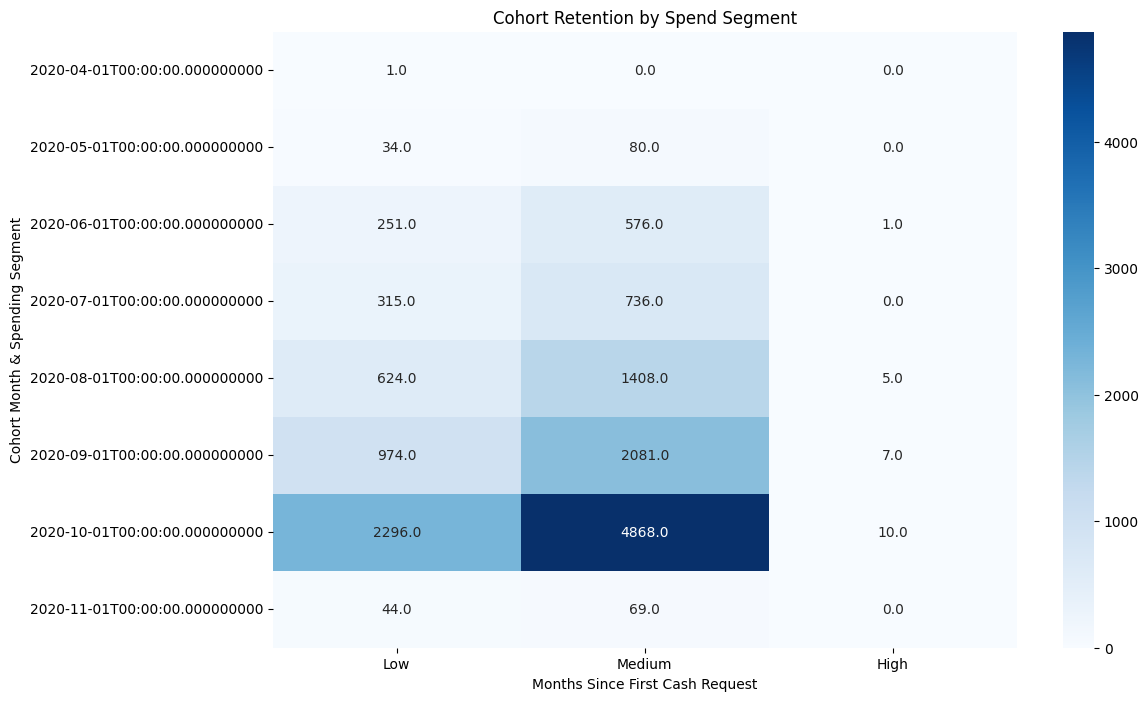

In [28]:
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot_spend, annot=True, fmt=".1f", cmap="Blues")
plt.title("Cohort Retention by Spend Segment")
plt.xlabel("Months Since First Cash Request")
plt.ylabel("Cohort Month & Spending Segment")
plt.show()

In [29]:
# Aggregate user-level data

user_features = merged_df.groupby('user_id').agg(
    num_requests=('user_id', 'count'),  # Total requests per user
    avg_amount=('amount', 'mean'),  # Average amount per request
    total_amount=('amount', 'sum'),  # Total borrowed amount
    first_request_month=('Month_cash_request', 'min'),  # First request date
    last_request_month=('Month_cash_request', 'max'),  # Last request date
    fees_paid=('total_amount', 'sum')  # Total fees paid
).reset_index()

# Convert first request month into categorical time periods
user_features['first_request_month'] = pd.to_datetime(user_features['first_request_month'], errors='coerce')
user_features['last_request_month'] = pd.to_datetime(user_features['last_request_month'], errors='coerce')


# Calculate user activity duration in days
user_features['user_lifetime'] = (user_features['last_request_month'] - user_features['first_request_month']).dt.days

# Convert first request month into categorical time periods (YYYY-MM format)
user_features['first_request_month'] = user_features['first_request_month'].dt.to_period('M')

# Classify users into spending segments
def classify_segment(amount):
    if amount < 100:  # Define thresholds based on data distribution
        return 'Low'
    elif amount < 500:
        return 'Medium'
    else:
        return 'High'

user_features['spend_segment'] = user_features['total_amount'].apply(classify_segment)

# Drop unnecessary columns
user_features = user_features.drop(columns=['last_request_month'])

user_features

,user_id,num_requests,avg_amount,total_amount,first_request_month,fees_paid,user_lifetime,spend_segment
0,47.0,10,8.1,81.0,2020-05,50.0,153,Low
1,52.0,2,15.0,30.0,2020-08,10.0,31,Low
2,53.0,1,100.0,100.0,2020-10,5.0,0,Medium
3,72.0,5,56.0,280.0,2020-07,25.0,62,Medium
4,73.0,2,100.0,200.0,2020-09,10.0,30,Medium
...,...,...,...,...,...,...,...,...
8867,103421.0,1,50.0,50.0,2020-11,5.0,0,Low
8868,103425.0,1,100.0,100.0,2020-11,5.0,0,Medium
8869,103437.0,1,100.0,100.0,2020-11,5.0,0,Medium
8870,103496.0,1,100.0,100.0,2020-11,5.0,0,Medium


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Set The Random Seed
random_seed=42

# Seprate the Features and the Target coulmns
target=user_features['spend_segment']
features=user_features.drop(columns=['user_id','spend_segment', 'first_request_month'])

# Convert datetime to numeric months


# Encode the spend_segment by LbabelEncoder
label_encoder=LabelEncoder()
target=label_encoder.fit_transform(target)

# Scale The Features With StandardScaler 
standard_scaler= StandardScaler()
features= standard_scaler.fit_transform(features)

# Split Data for Interpolationa, Extrapolation, Train and Test
X_interap, X_extrap, y_interap, y_extrap= train_test_split(features, target, test_size=0.3, random_state= random_seed, shuffle=False)
# X_train, X_test, Y_train, Y_test = train_test_split(X_interap, y_interap, test_size=0.2, random_state=random_seed, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_interap, y_interap, test_size=0.3, random_state=random_seed, shuffle=True)

# Create a SVM Model With RBF Kernel
svm_model= SVC(kernel='rbf', C=1, gamma=0.1, probability=True)

# Perform 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
cv_scores = cross_val_score(svm_model, features, target, cv=kf, scoring='accuracy')

# Display cross-validation results
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation of Accuracy:", np.std(cv_scores))


svm_model.fit(X_train, y_train)

Cross-Validation Scores: [0.98873239 0.98816901 0.98816234 0.99492672 0.99154453]
Mean Accuracy: 0.9903070009686076
Standard Deviation of Accuracy: 0.002627668312590126


SVC(C=1, gamma=0.1, probability=True)

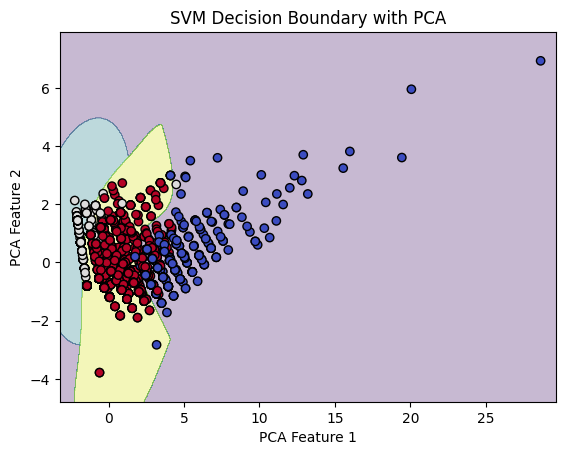

In [31]:
from sklearn.decomposition import PCA
# Reduce features to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Transform training data
X_test_pca = pca.transform(X_test)

# Train SVM on PCA-reduced data
svm_pca_model = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
svm_pca_model.fit(X_train_pca, y_train)

# Visualize the descision area
# Define mesh step size
h_svm = 0.02  

# Extract PCA feature limits
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()



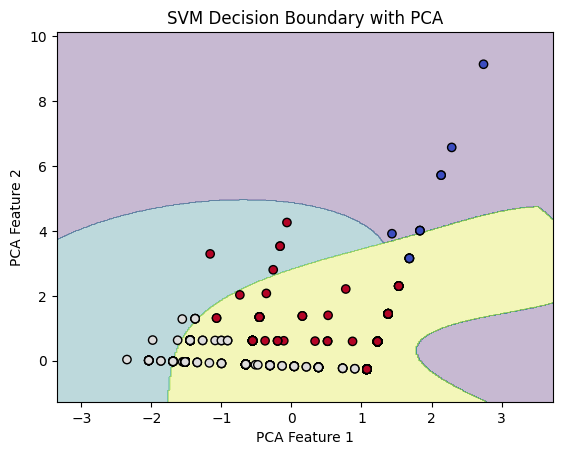

In [32]:
X_extrap_pca = pca.fit_transform(X_extrap)  # Transform training data 

# Visualize the descision area
# Define mesh step size
h_svm = 0.02  

# Extract PCA feature limits
x_min, x_max = X_extrap_pca[:, 0].min() - 1, X_extrap_pca[:, 0].max() + 1
y_min, y_max = X_extrap_pca[:, 1].min() - 1, X_extrap_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_extrap_pca[:, 0], X_extrap_pca[:, 1], c=y_extrap, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer


# Classification Report For The Test Data 
y_pred_test = svm_model.predict(X_test)

# Print accuracy
from sklearn.metrics import accuracy_score, classification_report
print('-'*50,'\n','Test')
print("SVM Model Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Confusion Matrix 
cm_svm= confusion_matrix(y_test, y_pred_test)
print(cm_svm)

y_pred_extrap = svm_model.predict(X_extrap)

print('-'*50,'\n','Extrapolation')
print("SVM Model Accuracy:", accuracy_score(y_extrap, y_pred_extrap))
print("Classification Report:\n", classification_report(y_extrap, y_pred_extrap))
cm_svm_extrap= confusion_matrix(y_extrap, y_pred_extrap)
print(cm_svm_extrap)

-------------------------------------------------- 
 Test
SVM Model Accuracy: 0.9871175523349437
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       182
           1       1.00      0.94      0.97       363
           2       0.98      1.00      0.99      1318

    accuracy                           0.99      1863
   macro avg       0.99      0.98      0.98      1863
weighted avg       0.99      0.99      0.99      1863

[[ 181    0    1]
 [   0  343   20]
 [   3    0 1315]]
-------------------------------------------------- 
 Extrapolation
SVM Model Accuracy: 0.9868519909842224
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.97      0.99      1300
           2       0.97      1.00      0.99      1349

    accuracy                           0.99      2662
   macro avg       0.99      0.99      0.

In [34]:
from sklearn.preprocessing import LabelBinarizer
# AUC for each class 
lb_svm= LabelBinarizer()
y_test_bin= lb_svm.fit_transform(y_test)
y_pred_prob_test= svm_model.predict_proba(X_test)

y_extrap_bin= lb_svm.fit_transform(y_extrap)
y_pred_prob_extrap= svm_model.predict_proba(X_extrap)


# Calculate the AUC for each class 
auc_scores_test=[]

for i in range(y_test_bin.shape[-1]):
    auc_test= roc_auc_score(y_test_bin[:,i], y_pred_prob_test[:,i])
    auc_scores_test.append(auc_test)

auc_scores_extrap=[]

for i in range(y_extrap_bin.shape[1]):
    auc_extrapt= roc_auc_score(y_extrap_bin[:,i], y_pred_prob_extrap[:,i])
    auc_scores_extrap.append(auc_test)

# Print the AUC for Each Class in The Test 
print('-'*50)
print('Interpolation')
for i , auc_test in enumerate(auc_scores_test):
    print(f"AUC pf the class{i}: {auc_test}")
print('-'*50)
print('Extrapolation')
# Print the AUC for Each Class in The Test 
for i , auc_extrap in enumerate(auc_scores_extrap):
    print(f"AUC pf the class{i}: {auc_extrap}")

--------------------------------------------------
Interpolation
AUC pf the class0: 0.9999411653189166
AUC pf the class1: 0.9999889807162534
AUC pf the class2: 0.9999136862914341
--------------------------------------------------
Extrapolation
AUC pf the class0: 0.9999136862914341
AUC pf the class1: 0.9999136862914341
AUC pf the class2: 0.9999136862914341


In [35]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']  # Kernel types
}

# Create SVM model
svm_model = SVC(probability=True)
# Define K-Fold Cross-Validation strategy (Stratified ensures class balance)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Implement GridSearchCV with K-Fold CV
grid_search = GridSearchCV(svm_model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=3)


# Fit on training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_svm_model = grid_search.best_estimator_

# Evaluate the best model on test data
test_accuracy = best_svm_model.score(X_test, y_test)
print("Test Accuracy of Best Model:", test_accuracy)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Hyperparameters: {'C': 100, 'gamma': 0.01, 'kernel': 'linear'}
Test Accuracy of Best Model: 0.9989264626945786


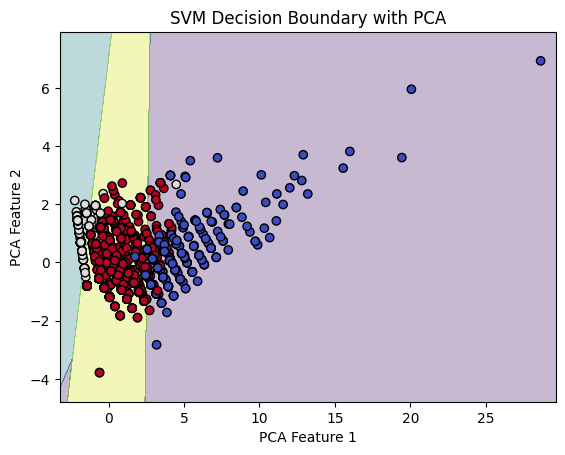

In [36]:
from sklearn.decomposition import PCA
# Reduce features to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Transform training data
X_test_pca = pca.transform(X_test)

# Train SVM on PCA-reduced data
svm_pca_best_model = SVC(kernel='linear', C=100, gamma=0.01, probability=True)
svm_pca_best_model.fit(X_train_pca, y_train)

# Visualize the descision area
# Define mesh step size
h_svm = 0.02  

# Extract PCA feature limits
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()

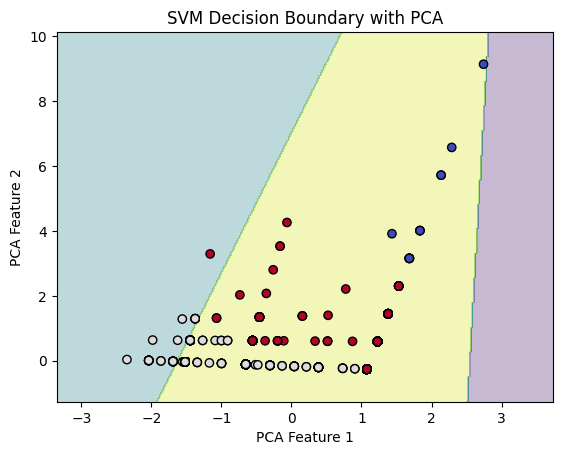

In [37]:
X_extrap_pca = pca.fit_transform(X_extrap)  # Transform training data


# Visualize the descision area
# Define mesh step size
h_svm = 0.02  

# Extract PCA feature limits
x_min, x_max = X_extrap_pca[:, 0].min() - 1, X_extrap_pca[:, 0].max() + 1
y_min, y_max = X_extrap_pca[:, 1].min() - 1, X_extrap_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_extrap_pca[:, 0], X_extrap_pca[:, 1], c=y_extrap, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()

In [38]:
# AUC for each class 
lb_svm= LabelBinarizer()
y_test_bin= lb_svm.fit_transform(y_test)
y_pred_prob_test= best_svm_model.predict_proba(X_test)

y_extrap_bin= lb_svm.fit_transform(y_extrap)
y_pred_prob_extrap= best_svm_model.predict_proba(X_extrap)


# Calculate the AUC for each class 
auc_scores_test=[]

for i in range(y_test_bin.shape[-1]):
    auc_test= roc_auc_score(y_test_bin[:,i], y_pred_prob_test[:,i])
    auc_scores_test.append(auc_test)

auc_scores_extrap=[]

for i in range(y_extrap_bin.shape[1]):
    auc_extrapt= roc_auc_score(y_extrap_bin[:,i], y_pred_prob_extrap[:,i])
    auc_scores_extrap.append(auc_test)

# Print the AUC for Each Class in The Test 
print('-'*50)
print('Interpolation')
for i , auc_test in enumerate(auc_scores_test):
    print(f"AUC pf the class{i}: {auc_test}")
print('-'*50)
print('Extrapolation')
# Print the AUC for Each Class in The Test 
for i , auc_extrap in enumerate(auc_scores_extrap):
    print(f"AUC pf the class{i}: {auc_extrap}")

--------------------------------------------------
Interpolation
AUC pf the class0: 0.9999280909453426
AUC pf the class1: 1.0
AUC pf the class2: 0.999926215700742
--------------------------------------------------
Extrapolation
AUC pf the class0: 0.999926215700742
AUC pf the class1: 0.999926215700742
AUC pf the class2: 0.999926215700742


#### KNN

In [39]:
from sklearn.neighbors import KNeighborsClassifier

# Set up the KNN model with n_neighbors= 10 
n_neighbors= 10
knn_model = KNeighborsClassifier(n_neighbors = n_neighbors)
knn_model.fit(X_train, y_train)



KNeighborsClassifier(n_neighbors=10)

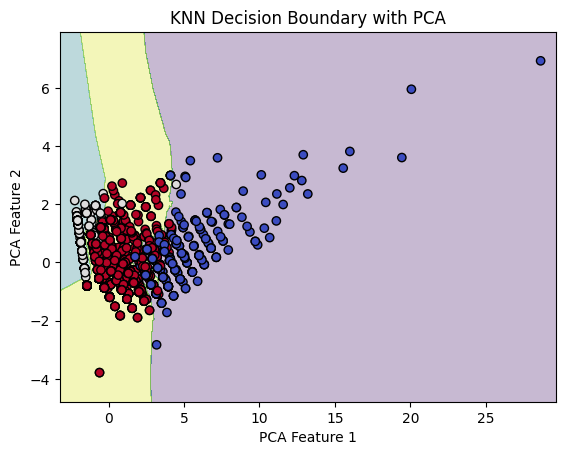

In [40]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Transform training data
X_test_pca = pca.transform(X_test)

# Train SVM on PCA-reduced data
knn_pca_model = KNeighborsClassifier(n_neighbors = n_neighbors)
knn_pca_model.fit(X_train_pca, y_train)

# Visualize the descision area
# Define mesh step size
h_knn = 0.02  

# Extract PCA feature limits
x_min_knn, x_max_knn = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min_knn, y_max_knn = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min_knn, x_max_knn, h_knn),
    np.arange(y_min_knn, y_max_knn, h_knn)
)

# Predict on mesh grid using SVM trained on PCA data
Z = knn_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("KNN Decision Boundary with PCA")
plt.show()

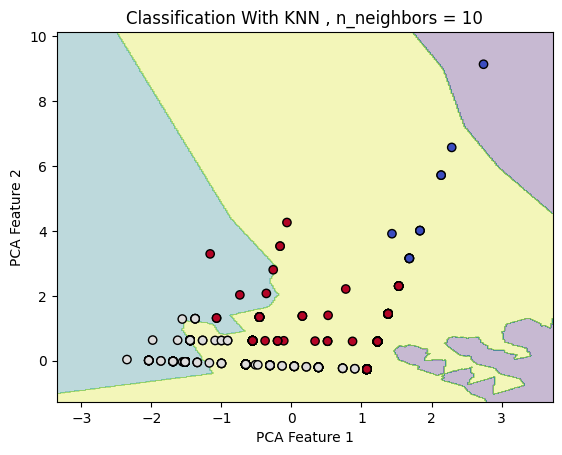

In [41]:
pca = PCA(n_components=2)
X_extrap_pca = pca.fit_transform(X_extrap)  # Transform training data
X_extrap_pca = pca.transform(X_extrap)


# Visualize the descision area
# Define mesh step size
h_knn = 0.02  

# Extract PCA feature limits
x_min_knn, x_max_knn = X_extrap_pca[:, 0].min() - 1, X_extrap_pca[:, 0].max() + 1
y_min_knn, y_max_knn = X_extrap_pca[:, 1].min() - 1, X_extrap_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min_knn, x_max_knn, h_knn),
    np.arange(y_min_knn, y_max_knn, h_knn)
)

# Predict on mesh grid using SVM trained on PCA data
Z = knn_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, camp='viridis')
plt.scatter(X_extrap_pca[:, 0], X_extrap_pca[:, 1], c=y_extrap, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("Classification With KNN , n_neighbors = 10")
plt.show()

In [42]:
y_pred_test_knn = knn_model.predict(X_test)
y_pred_extrap_knn= knn_model.predict(X_extrap)

print('Classification Report:')
print(classification_report(y_test, y_pred_test_knn))
print(classification_report(y_extrap, y_pred_extrap_knn))

cm_matrix_test = confusion_matrix(y_test,y_pred_test_knn)
print('Confusion Matrix for the test data:')
print(cm_matrix_test)

cm_matrix_extrap = confusion_matrix(y_extrap,y_pred_extrap_knn)
print('Confusion Matrix for the extrapolation data:')
print(cm_matrix_extrap)

# AUC for each class 
lb_knn= LabelBinarizer()
y_test_bin= lb_svm.fit_transform(y_test)
y_pred_prob_test= knn_model.predict_proba(X_test)

y_extrap_bin= lb_knn.fit_transform(y_extrap)
y_pred_prob_extrap= knn_model.predict_proba(X_extrap)


# Calculate the AUC for each class 
auc_scores_test=[]

for i in range(y_test_bin.shape[-1]):
    auc_test= roc_auc_score(y_test_bin[:,i], y_pred_prob_test[:,i])
    auc_scores_test.append(auc_test)

auc_scores_extrap=[]

for i in range(y_extrap_bin.shape[1]):
    auc_extrapt= roc_auc_score(y_extrap_bin[:,i], y_pred_prob_extrap[:,i])
    auc_scores_extrap.append(auc_test)

# Print the AUC for Each Class in The Test 
print('-'*50)
print('Interpolation')
for i , auc_test in enumerate(auc_scores_test):
    print(f"AUC pf the class{i}: {auc_test}")
print('-'*50)
print('Extrapolation')
# Print the AUC for Each Class in The Test 
for i , auc_extrap in enumerate(auc_scores_extrap):
    print(f"AUC pf the class{i}: {auc_extrap}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       182
           1       1.00      0.98      0.99       363
           2       0.99      0.99      0.99      1318

    accuracy                           0.99      1863
   macro avg       0.98      0.99      0.99      1863
weighted avg       0.99      0.99      0.99      1863

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00      1300
           2       1.00      1.00      1.00      1349

    accuracy                           1.00      2662
   macro avg       1.00      1.00      1.00      2662
weighted avg       1.00      1.00      1.00      2662

Confusion Matrix for the test data:
[[ 181    0    1]
 [   0  356    7]
 [   8    1 1309]]
Confusion Matrix for the extrapolation data:
[[  13    0    0]
 [   0 1296    4]
 [   0    1 1348]]
------------------------

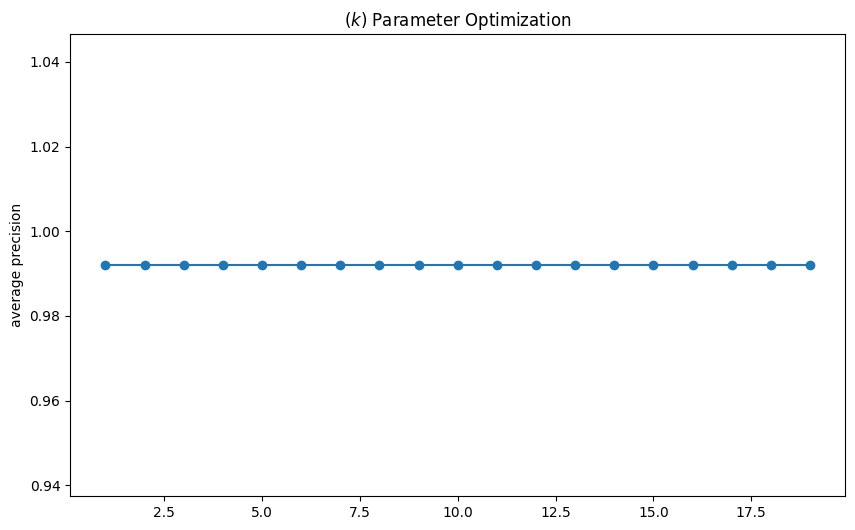

In [43]:
k_values_knn = range(1, 20)
accuracies_knn = []

for k_knn in k_values_knn :
    Knn_model = KNeighborsClassifier(n_neighbors = k_knn)
    scores_knn= cross_val_score(knn_model, X_train , y_train,cv=5)
    accuracies_knn.append(scores_knn.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_values_knn, accuracies_knn, marker='o')
plt.title('($k$) Parameter Optimization')
plt.ylabel('average precision')
plt.show()